# Tutorial Node2Vec con PyTorch Geometric
Questo tutorial mostra come implementare l'algoritmo Node2Vec utilizzando PyTorch Geometric,
applicandolo prima al grafo di Zachary's Karate Club e poi a un grafo Barbell 


In [3]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.manifold import TSNE
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx, from_networkx

# Imposta il seed per la riproducibilità
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Applicazione di Node2Vec al grafo di Zachary's Karate Club
print("Parte 1: Zachary's Karate Club")
print("-" * 50)

# Carica il dataset Zachary's Karate Club
dataset = KarateClub()
data = dataset[0]
print(f"Informazioni sul grafo:")
print(f"  Numero di nodi: {data.num_nodes}")
print(f"  Numero di archi: {data.num_edges // 2}")  # Diviso per 2 perché gli archi sono non diretti e contati due volte
print(f"  Numero di feature per nodo: {data.num_node_features}")
print(f"  Numero di classi: {dataset.num_classes}")

# Converti il grafo in formato NetworkX per la visualizzazione
G = to_networkx(data, to_undirected=True)

Parte 1: Zachary's Karate Club
--------------------------------------------------
Informazioni sul grafo:
  Numero di nodi: 34
  Numero di archi: 78
  Numero di feature per nodo: 34
  Numero di classi: 4


In [4]:
# Implementazione di Node2Vec
def train_node2vec(data, embedding_dim=64, walk_length=20, context_size=10, walks_per_node=10, p=1, q=1, epochs=100):
    """
    Addestra un modello Node2Vec sul grafo dato
    
    Parametri:
    - data: Oggetto torch_geometric.data.Data contenente il grafo
    - embedding_dim: Dimensione dei vettori di embedding finali
    - walk_length: Lunghezza di ogni random walk
    - context_size: Dimensione della finestra di contesto
    - walks_per_node: Numero di random walk per nodo
    - p: Parametro di ritorno (1 è neutrale)
    - q: Parametro di esplorazione (1 è neutrale)
    - epochs: Numero di epoche di addestramento
    
    Ritorna:
    - z: Embedding finali dei nodi
    - model: Modello Node2Vec addestrato
    """
    # Inizializza il modello Node2Vec fornendo la struttura del grafo (edge_index) e tutti i parametri
    # edge_index: Indici degli archi del grafo in formato COO (coordinate list)
    # embedding_dim: Numero di dimensioni dello spazio vettoriale in cui mappare i nodi
    # walk_length: Quanti nodi visitare in ciascun random walk
    # context_size: Dimensione della finestra per considerare i nodi vicini (analogo a word2vec)
    # walks_per_node: Quanti random walk iniziare da ciascun nodo del grafo
    # p: Parametro che controlla la probabilità di tornare al nodo precedente (p basso = più probabile tornare indietro)
    # q: Parametro che controlla l'esplorazione (q basso = più esplorazione in ampiezza)
    # sparse: Usa ottimizzazioni per grafi sparsi
    model = Node2Vec(
        data.edge_index,  # La topologia del grafo in formato di indici degli archi
        embedding_dim=embedding_dim,  # Dimensione del vettore di embedding per ciascun nodo
        walk_length=walk_length,  # Lunghezza di ciascun random walk
        context_size=context_size,  # Dimensione della finestra di contesto
        walks_per_node=walks_per_node,  # Numero di random walk per ogni nodo
        p=p,  # Parametro di ritorno: controlla la probabilità di revisitare nodi
        q=q,  # Parametro di esplorazione: controlla se esplorare a distanza o restare in vicinanza
        sparse=True  # Usa implementazione sparsa per efficienza di memoria
    )
    
    # Crea un data loader per addestrare il modello in batch
    # Questo genera automaticamente coppie positive e negative di contesti
    # batch_size: Numero di esempi da processare contemporaneamente
    # shuffle: Mischia i dati ad ogni epoca per una migliore generalizzazione
    
    loader = model.loader(batch_size=64, shuffle=True)
    
    # Inizializza l'ottimizzatore SparseAdam, specializzato per parametri sparsi
    # list(model.parameters()): Tutti i parametri addestrabili del modello
    # lr: Learning rate, controlla la dimensione dei passi di aggiornamento
    
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
    
    # Imposta il modello in modalità addestramento per abilitare il calcolo dei gradienti
    model.train()
    
    # Ciclo principale di addestramento, ripetuto per il numero specificato di epoche
    for epoch in range(1, epochs+1):
        # Resetta la loss totale all'inizio di ogni epoca
        total_loss = 0
        
        # Itera attraverso i batch generati dal loader
        # pos_rw: Random walk positivi (contesti veri)
        # neg_rw: Random walk negativi (contesti casuali per negative sampling)
        for pos_rw, neg_rw in loader:
            # Azzera i gradienti accumulati dall'ottimizzatore per evitare accumulo
            optimizer.zero_grad()
            
            # Calcola la funzione di loss per questo batch
            # Usa il positive sampling e il negative sampling per apprendere rappresentazioni utili
            loss = model.loss(pos_rw, neg_rw)
            
            # Calcola i gradienti rispetto a tutti i parametri con backpropagation
            loss.backward()
            
            # Aggiorna i parametri del modello usando l'ottimizzatore
            optimizer.step()
            
            # Accumula la loss per monitoraggio
            total_loss += loss.item()  # .item() converte il tensore in un valore scalare
        
        # Mostra lo stato dell'addestramento ogni 50  epoche
        if epoch % 50 == 0:
            # Calcola e stampa la loss media per batch in questa epoca
            print(f'Epoch: {epoch:02d}, Loss: {total_loss/len(loader):.4f}')
    
    # Addestramento completato, imposta il modello in modalità valutazione
    # Questo disabilita dropout, batch normalization, ecc.
    model.eval()
    
    # Genera gli embedding finali per tutti i nodi senza calcolare gradienti
    # Questo è più efficiente e usa meno memoria
    with torch.no_grad():
        # Chiama il modello senza argomenti per ottenere tutti gli embedding
        z = model()
    
    # Restituisce sia gli embedding finali che il modello addestrato
    # z: Matrice di embedding (num_nodi x embedding_dim)
    # model: Il modello addestrato che può essere usato per ulteriori inferenze
    return z, model

In [7]:
# Addestra il modello Node2Vec sul grafo Karate Club
print("\nAddestramento del modello Node2Vec sul grafo Karate Club...")
embeddings, model = train_node2vec(
    data,
    embedding_dim=5,
    walk_length=4,
    context_size=4,
    walks_per_node=4,
    p=1,  # probabilità il ritorno 1/p
    q=1,  # 1/q modella il rapporto BFS/DFS
    epochs=500
)


Addestramento del modello Node2Vec sul grafo Karate Club...
Epoch: 10, Loss: 2.0551
Epoch: 20, Loss: 1.9227
Epoch: 30, Loss: 1.7294
Epoch: 40, Loss: 1.7158
Epoch: 50, Loss: 1.5231
Epoch: 60, Loss: 1.5244
Epoch: 70, Loss: 1.4695
Epoch: 80, Loss: 1.4156
Epoch: 90, Loss: 1.3771
Epoch: 100, Loss: 1.3840
Epoch: 110, Loss: 1.3142
Epoch: 120, Loss: 1.3362
Epoch: 130, Loss: 1.3120
Epoch: 140, Loss: 1.3036
Epoch: 150, Loss: 1.2825
Epoch: 160, Loss: 1.3028
Epoch: 170, Loss: 1.2517
Epoch: 180, Loss: 1.2156
Epoch: 190, Loss: 1.2237
Epoch: 200, Loss: 1.2144
Epoch: 210, Loss: 1.2170
Epoch: 220, Loss: 1.1965
Epoch: 230, Loss: 1.1816
Epoch: 240, Loss: 1.2348
Epoch: 250, Loss: 1.2245
Epoch: 260, Loss: 1.2356
Epoch: 270, Loss: 1.1685
Epoch: 280, Loss: 1.2159
Epoch: 290, Loss: 1.2165
Epoch: 300, Loss: 1.2194
Epoch: 310, Loss: 1.2131
Epoch: 320, Loss: 1.1809
Epoch: 330, Loss: 1.2298
Epoch: 340, Loss: 1.1647
Epoch: 350, Loss: 1.1629
Epoch: 360, Loss: 1.1908
Epoch: 370, Loss: 1.1947
Epoch: 380, Loss: 1.141

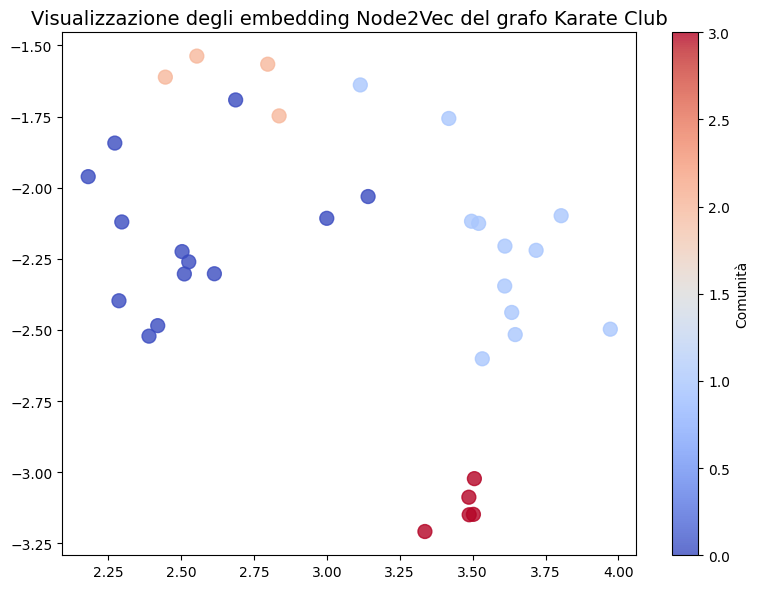

In [8]:
# Applica t-SNE per visualizzare gli embedding in 2D
embeddings_np = embeddings.detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(embeddings_np)

# Ottieni le etichette dei club (0 o 1) per la colorazione
node_colors = data.y.numpy()

# Visualizza gli embedding con t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colors,
    cmap="coolwarm",
    alpha=0.8,
    s=100
)

plt.title("Visualizzazione degli embedding Node2Vec del grafo Karate Club", fontsize=14)
plt.colorbar(label="Comunità")
plt.tight_layout()
plt.savefig("karate_club_embeddings.png")
#plt.close()

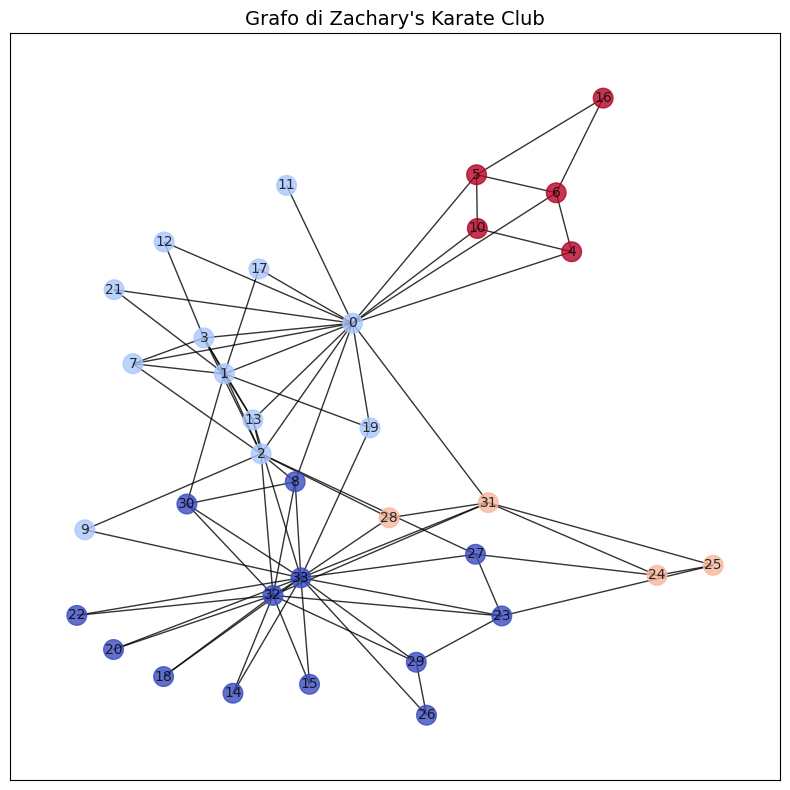

In [9]:
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(
    G,
    pos=pos,
    node_color=node_colors,
    cmap="coolwarm",
    node_size=200,
    with_labels=True,
    width=1.0,
    alpha=0.8,
    font_size=10
)
plt.title("Grafo di Zachary's Karate Club", fontsize=14)
plt.tight_layout()
plt.savefig("karate_club_graph.png")
#plt.close()


Analisi dell'effetto dei parametri p e q su Node2Vec
Addestramento con p=0.5, q=0.5
Epoch: 10, Loss: 1.7649
Epoch: 20, Loss: 1.6795
Epoch: 30, Loss: 1.6275
Epoch: 40, Loss: 1.5395
Epoch: 50, Loss: 1.4987
Epoch: 60, Loss: 1.4590
Epoch: 70, Loss: 1.4513
Epoch: 80, Loss: 1.4401
Epoch: 90, Loss: 1.4084
Epoch: 100, Loss: 1.3871
Epoch: 110, Loss: 1.3909
Epoch: 120, Loss: 1.3887
Epoch: 130, Loss: 1.3685
Epoch: 140, Loss: 1.3676
Epoch: 150, Loss: 1.3340
Epoch: 160, Loss: 1.3354
Epoch: 170, Loss: 1.3219
Epoch: 180, Loss: 1.3074
Epoch: 190, Loss: 1.3044
Epoch: 200, Loss: 1.3095
Epoch: 210, Loss: 1.2954
Epoch: 220, Loss: 1.2872
Epoch: 230, Loss: 1.2755
Epoch: 240, Loss: 1.2787
Epoch: 250, Loss: 1.2816
Epoch: 260, Loss: 1.2833
Epoch: 270, Loss: 1.2626
Epoch: 280, Loss: 1.2668
Epoch: 290, Loss: 1.2695
Epoch: 300, Loss: 1.2587
Epoch: 310, Loss: 1.2486
Epoch: 320, Loss: 1.2492
Epoch: 330, Loss: 1.2593
Epoch: 340, Loss: 1.2470
Epoch: 350, Loss: 1.2351
Epoch: 360, Loss: 1.2613
Epoch: 370, Loss: 1.2254

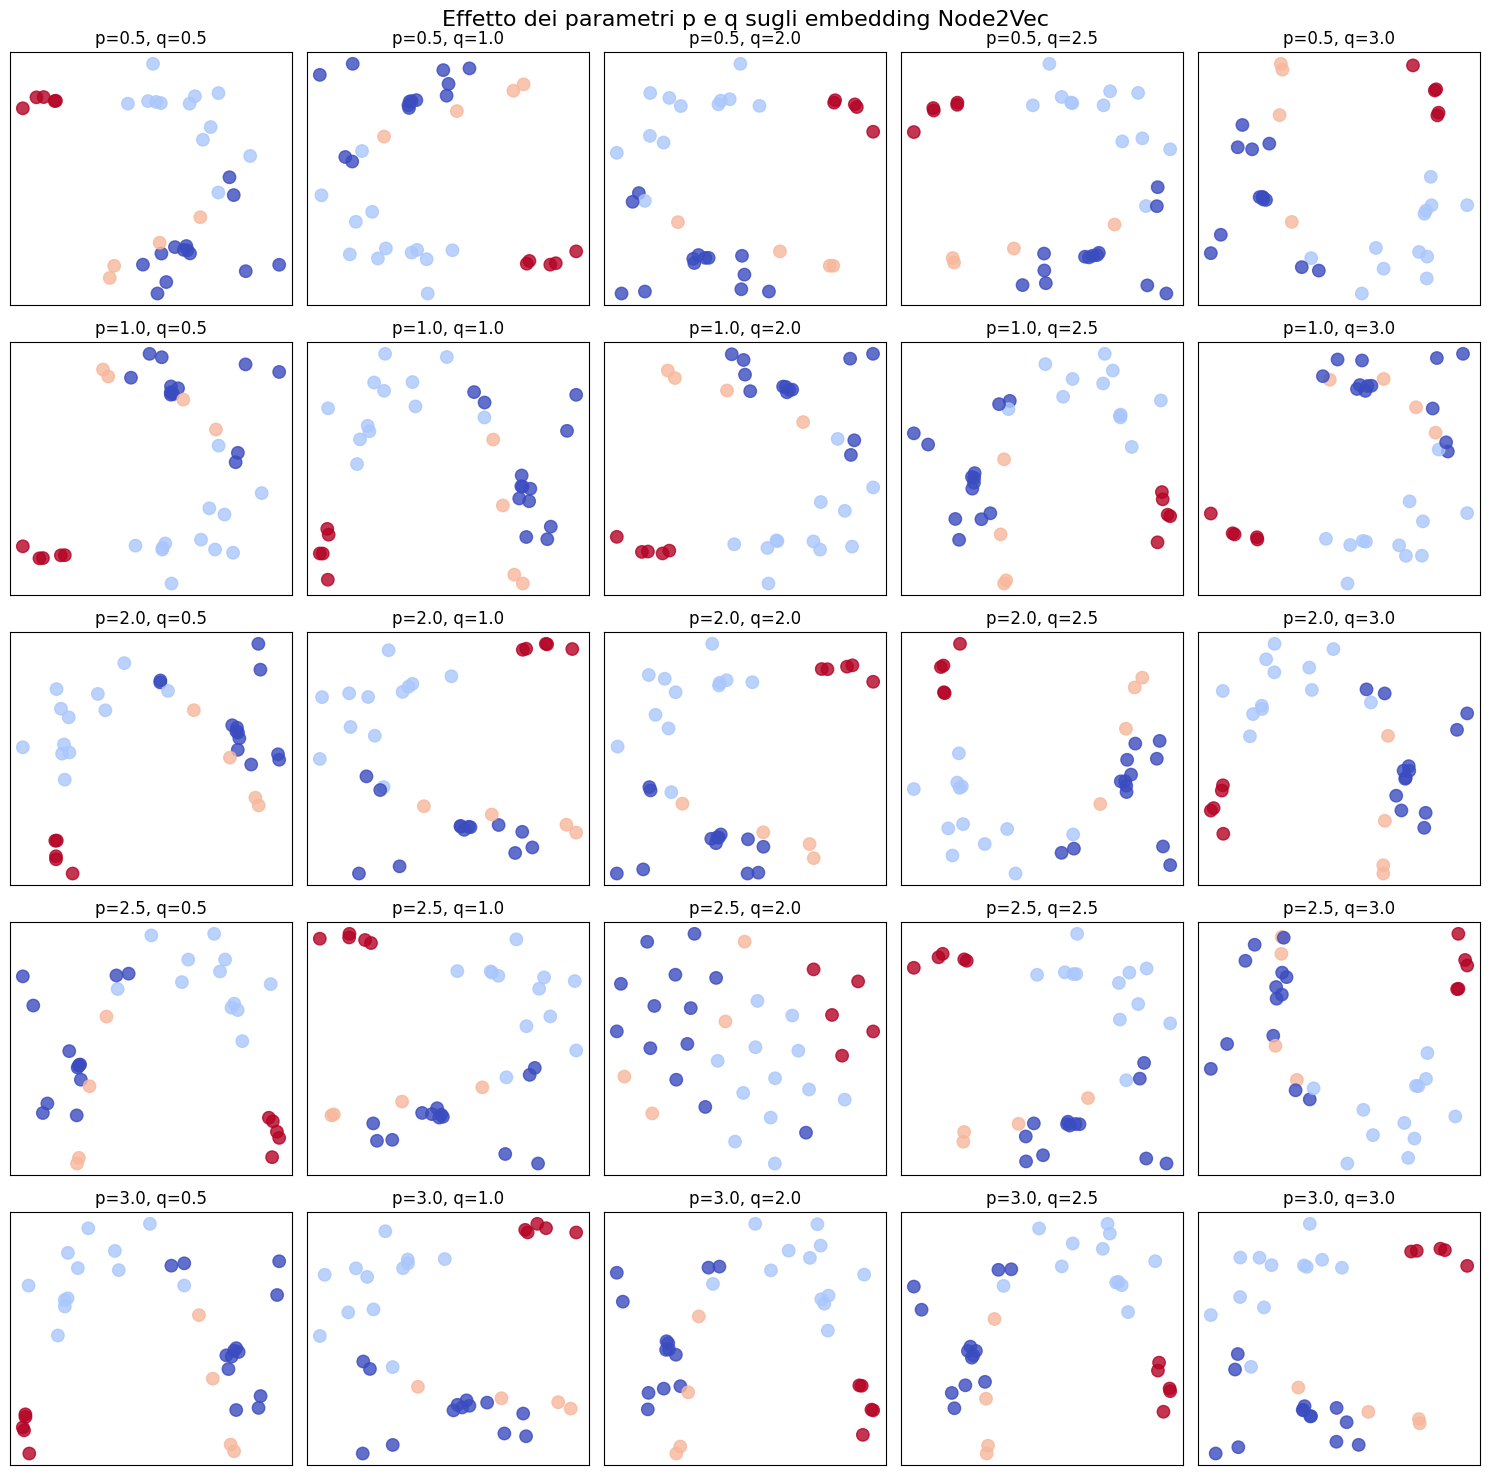

In [10]:
print("\nAnalisi dell'effetto dei parametri p e q su Node2Vec")
p_values = [0.5, 1.0, 2.0,2.5,3.0]
q_values = [0.5, 1.0, 2.0,2.5,3.0]

fig, axes = plt.subplots(len(p_values), len(q_values), figsize=(15, 15))

for i, p in enumerate(p_values):
    for j, q in enumerate(q_values):
        print(f"Addestramento con p={p}, q={q}")
        embeddings, _ = train_node2vec(
            data,
            embedding_dim=2,
            walk_length=6,
            context_size=6,
            walks_per_node=15,
            p=p,
            q=q,
            epochs=100  
        )
        
        # Applica t-SNE
        embeddings_np = embeddings.detach().numpy()
        node_embeddings_2d = tsne.fit_transform(embeddings_np)
        
        # Visualizza
        axes[i, j].scatter(
            node_embeddings_2d[:, 0],
            node_embeddings_2d[:, 1],
            c=node_colors,
            cmap="coolwarm",
            alpha=0.8,
            s=80
        )
        axes[i, j].set_title(f"p={p}, q={q}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.suptitle("Effetto dei parametri p e q sugli embedding Node2Vec", fontsize=16)
plt.tight_layout()
plt.savefig("node2vec_parameters.png")


===
Parte 2: Grafo Barbell di 6 nodi
Creato grafo Barbell con 6 nodi e 7 archi


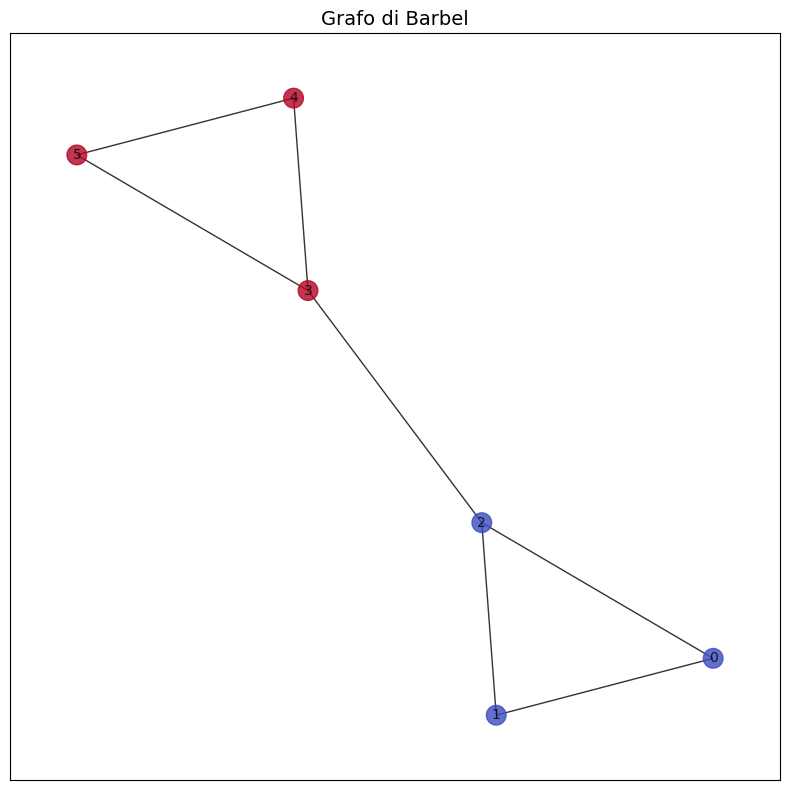

In [4]:
# Applicazione a un grafo Barbell di grandi dimensioni
print("\n" + "=" * 3)
print("Parte 2: Grafo Barbell di 6 nodi")
print("=" *6)

def create_barbell_graph(m, k=None):
    """
    Crea un grafo Barbell con 2*m nodi (o m+k nodi se k è specificato)
    
    Parametri:
    - m: Dimensione di ciascuna clique
    - k: Numero di nodi nel 'ponte' tra le clique (default: 0)
    
    Ritorna:
    - Grafo NetworkX
    """
    if k is None:
        return nx.barbell_graph(m, 0)
    else:
        return nx.barbell_graph(m, k)

# Crea un grafo Barbell con 100 nodi (due clique da 50 nodi)
m = 3  # Dimensione di ciascuna clique
barbell_graph = create_barbell_graph(m)
print(f"Creato grafo Barbell con {barbell_graph.number_of_nodes()} nodi e {barbell_graph.number_of_edges()} archi")

# Assegna etichette fittizie per visualizzazione: 0 per la prima clique, 1 per la seconda
node_labels = np.zeros(barbell_graph.number_of_nodes())
node_labels[m:] = 1  # Nodi nella seconda clique

# Converti da NetworkX a PyTorch Geometric
barbell_data = from_networkx(barbell_graph)
barbell_data.y = torch.tensor(node_labels, dtype=torch.long)


plt.figure(figsize=(8, 8))
pos = nx.spring_layout(barbell_graph, seed=42)
nx.draw_networkx(
    barbell_graph,
    pos=pos,
    node_color=node_labels,
    cmap="coolwarm",
    node_size=200,
    with_labels=True,
    width=1.0,
    alpha=0.8,
    font_size=10
)
plt.title("Grafo di Barbel", fontsize=14)
plt.tight_layout()
plt.savefig("barbel_graph.png")
#plt.close()

# Esercizio
1. Addestra Node2Vec su un grafo Barbell di 50 nodi. Scegli dei parametri idonei per l'addestramento.
2. visualizza il risultato sul piano. 
